In [1]:
%load_ext autoreload
%autoreload 2
# Reload modules if they've changed

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Install matplotlib2tikz
Using pip:
pip install -U matplotlib2tikz

# Run the following two cells every time the notebook starts

In [44]:
import numpy as np
import scipy as sp
from scipy.sparse.linalg import svds
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
%matplotlib inline
import flowField   
import impulseResponse as impres
import ops  # Linear dynamical system
import pseudo   # Wall-normal differentiation
import os
from warnings import warn
from matplotlib2tikz import save as tikzSave

import sys
assert sys.version_info >=(3,5), "The infix operator used for matrix multiplication isn't supported in versions earlier than python3.5. Install 3.5 or fix this code (replace A@B with np.dot(A,B) )"

dataFolder = '/kepler/sabarish/impulseResponse/'

In [38]:
figureFolder = 'testFigures/'
if not os.path.isdir('testFigures'): os.mkdir("testFigures")

# Simplified plotting to .eps
def savefig(figName):
    figName = figureFolder + figName
    if not figName.endswith('.eps'):
        figName = figName + '.eps'
    plt.savefig(figName, format='eps')
    print("Printed figure to ", figName)
    return

# Simplified plotting to .tikz
def tikzSaveSmall(fName):
    if not fName.startswith(figureFolder):
        fName = figureFolder + fName
    if not fName.endswith('.tex'):
        fName = fName.split('.')[0] + '.tex'

    # Define variables tmpFigHeight and tmpFigWidth that can be set in Tex
    tikzSave(fName,
            figureheight='\\tmpFigHeight',
            figurewidth ='\\tmpFigWidth')
    print("Saved tikz file to ", fName)
    return

forSuffix = lambda fsVec : "_Fs_%d_%d_%d"%(fsVec[0],fsVec[1],fsVec[2])
forTimeSuffix = lambda fsVec,t : "_Fs_%d_%d_%d_t%05d.mat"%(
    fsVec[0],fsVec[1],fsVec[2], round(100.*t))
y0ForSuffix = lambda y0, fsVec : "y0p%03d_Fs_%d_%d_%d"%(
    round(-1000.*y0), fsVec[0],fsVec[1],fsVec[2])
y0ForTimeSuffix = lambda y0, fsVec,t : "y0p%03d_Fs_%d_%d_%d_t%05d.mat"%(
    round(-1000.*y0),fsVec[0],fsVec[1],fsVec[2], round(100.*t))

# Wall-normal differentiation

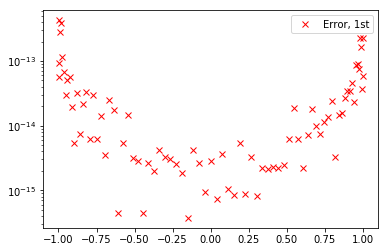

In [257]:
N = 81; nDiff = 2
y,DM = pseudo.chebdif(N,nDiff)
# y has shape (N,), and DM has shape (N,N,nDiff), nDiff is the number of derivatives needed
D1 = DM[:,:,0]
D2 = DM[:,:,1]

# We'll check results against test functions that are 0 at y= +/- 1 
a1 = 11.; i1=6; a2=-4.; i2=13
testFunction = (1-y**2) * ( a1*(y**i1) + a2*(y**i2)  )
firstDerivative = -2.*y*(a1*y**i1 + a2*y**i2) + (1.-y**2)*(
    a1*i1*y**(i1-1) + a2*i2*y**(i2-1))

plt.semilogy(y, np.abs(firstDerivative-D1@testFunction), 'rx', label='Error, 1st')

if False:
    #secondDerivative = 
    #plt.loglog(y, secondDerivative-D2@testFunction, 'b--', label='Error, 2nd')
    pass
plt.legend()
plt.show()



# Impulse response for channel flow

## $Re_\tau = 500$, turbulent, with eddy viscosity
## At $y^+=50$, and forced along each coordinate axis

# For a single Fourier mode, $(\alpha,\beta)=(2., 7.)$
At times, $t=\lbrack t_0:t_0:20t_0\rbrack$, $t_0 = 0.05$, non-dimensionalized by friction velocity and channel half-height.

/home/svadarevu/gitwork/linear/library/ops.py:243: UserWarning: Base velocity is being reset using ops.turbMeanChannel...
  warn('Base velocity is being reset using ops.turbMeanChannel...')


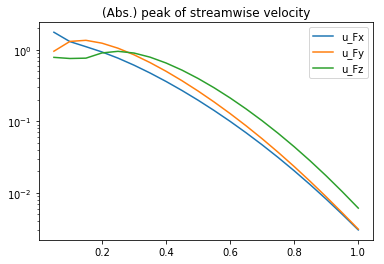

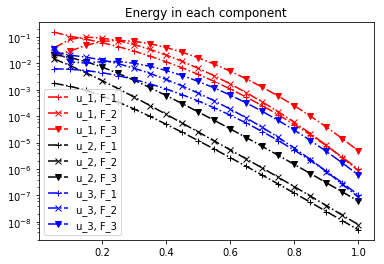

In [75]:
Re = 500.
N = 151 
# N must increase with increasing Re
turb = True

# Define 'linearize' class instance
linInst = ops.linearize(
            N=N, flowClass='channel', Re=Re, turb=turb)
# U, dU, and d2U (mean velocity and its derivatives) are defined by the class if 
#  not supplied, depending on the keyword 'turb'. 
# If False, U=1-y^2. 
# If True, they're obtained from ops.turbMeanChannel()


# System matrices can be obtained as
a = 2.; b = 7.
eddy = True
if False:
    systemDict = linInst.makeSystem(
        a=a, b=b, eddy=eddy, adjoint=True)
    A = systemDict['A']; B = systemDict['B']; C = systemDict['C']
    Aadj = systemDict['Aadj']; Badj = systemDict['Badj']; Cadj = systemDict['Cadj']

    
# Define impulse parameters
tArr = 0.05 * np.arange(1, 21)
fsAmp = np.identity(3)
# fsAmp defines forcing direction. It has to be shape (nForce, 3)
# Each of fsAmp[i,:] defines one case of impulse
# fsAmp[i,:] = (0.5, 0.5, 0) refers to a forcing that is zero along 'z' (spanwise)
#    and equal along 'x' (streamwise) and 'y' (wall-normal)
# The magnitudes 0.5 and 0.5 in the above case are not important, and they will be normalized

y0plus = 50. 
y0 = -1. + y0plus/Re    # This is the variable that has to be passed to code, not y0plus
eps = y0plus/4.    
# y0, eps, N, Re have to be supplied in a dict 'impulseArgs'
# y0 is the center of the approximate impulse, and eps specifies its width
#   Smaller 'eps' produces a sharper impulse, a larger one produces a smoother one. 
# For turbulent cases use eps ~ y0plus, while for laminar, use eps ~ (1/1000)
impulseArgs = {'y0':y0, 'eps':eps}
# See impulseResponse._fs0() for details
coeffs = True       # Flag to say we want Fourier coefficients as well as energy

# Compute impulse response 
impresDict = impres.timeMap(a,b,tArr,
         fsAmp=fsAmp, linInst=linInst, impulseArgs=impulseArgs,
         coeffs=coeffs, eddy=eddy )


# Unpack dictionary
coeffArr = impresDict['coeffArr'] # This has shape (tArr.size, 3N, nForce)
uPeaks = np.amax( np.abs(coeffArr[:,:N]) , axis=1) # Peak uu at each time 

energyArr = impresDict['energyArr'] # Has shape (tArr.size, 3, nForce)




plt.figure()
plt.title("(Abs.) peak of streamwise velocity")
plt.semilogy(tArr, uPeaks[:,0], label='u_Fx')
plt.semilogy(tArr, uPeaks[:,1], label='u_Fy')
plt.semilogy(tArr, uPeaks[:,2], label='u_Fz')
plt.legend()
plt.show()

plt.figure()
plt.title("Energy in each component")
clrArr = ['r','k','b']
symArr = ['+', 'x', 'v']
for i0 in range(3):
    for i1 in range(3):
        plt.semilogy(tArr, energyArr[:,i0,i1], 
                     '%s-.%s'%(clrArr[i0], symArr[i1]),
                     label='u_%d, F_%d'%(i0+1,i1+1))
plt.legend()
plt.show()




# Impulse response for a set of $(\alpha, \beta)$
## Turbulent, with eddy viscosity, $Re_\tau = 500$, forcing at $y^+ = 25$ along coordinate axes

In [76]:
Re = 500.; N = 151
turb = True; eddy = True
y0plus = 25.
fsAmp = np.identity(3)

Lx = 2.*np.pi; Lz = np.pi   # Domain size
L = 32; M = 32  # Number of positive Fourier wavenumbers 
t0 = 0.05; tArr = t0*np.arange(1., 11.)   # Time

#================================
a0 = 2.*np.pi/Lx; b0 = 2.*np.pi/Lz
eps = y0plus/4.; y0 = -1. + y0plus/Re
aArr = a0*np.arange(-L,L); bArr = b0*np.arange(0,M+1)
# bArr doesn't need negative wavenumbers, we can use real-valuedness to complete those coefficients


#Impulse response can be computed in two ways. 

## 1. Call impres.timeMap() explicitly and populate flowField instance for each time


In [82]:
#flowField(aArr, bArr, N, flowDict=flowDict); flowDict has keys 
flowState = 'turb'
if not turb: flowState = 'lam'
ffList =[]
warn("This takes a very long time if a lot of Fourier modes are involved.")
#=== Need these two to call impres.timeMap()
linInst = ops.linearize(N=N,flowClass='channel',Re=Re,turb=turb)
impulseArgs = {'y0':y0, 'eps':eps}

for i0 in range(tArr.size):
    t = tArr[i0]
    print("t:",t)
    for i3 in range(fsAmp.shape[0]):
        fsAmpVec = fsAmp[i3:i3+1]
        flowDict={'Re':Re, 'N':N, \
         'flowState':flowState, 'flowClass':'channel', 'eddy':eddy, 't':t}
        # Need a new instance of flowField.flowField for each time and forcing
        ff = flowField.flowField(aArr, bArr, N, flowDict=flowDict)
        # ff has shape (aArr.size, bArr.size, 3, N)
        for i1 in range(aArr.size):
            a = aArr[i1]
            for i2 in range(bArr.size):
                b = bArr[i2]
                impresDict = impres.timeMap(a,b,tArr[i0:i0+1], fsAmp=fsAmpVec,
                            coeffs=True,linInst=linInst, eddy=eddy, impulseArgs=impulseArgs)
                ff[i1,i2] = impresDict['coeffArr'].reshape((3,N))
        ffList.append(ff)
                


t: 0.05


/home/svadarevu/gitwork/linear/library/flowField.py:543: UserWarning: Using channel geometry, excluding walls; see kwargs of pseudo.chebdif() and pseudo.weightMats() for differentiation/integration matrices that could include walls.
  warn("Using channel geometry, excluding walls; see kwargs of pseudo.chebdif() and pseudo.weightMats() for differentiation/integration matrices that could include walls.")
/home/svadarevu/gitwork/linear/library/ops.py:243: UserWarning: Base velocity is being reset using ops.turbMeanChannel...
  warn('Base velocity is being reset using ops.turbMeanChannel...')
/home/svadarevu/gitwork/linear/library/ops.py:298: RuntimeWarning: divide by zero encountered in double_scalars
  C = (1./k2) * np.vstack((
/home/svadarevu/gitwork/linear/library/ops.py:301: RuntimeWarning: invalid value encountered in multiply
  np.hstack((1.j*b*D1,  1.j*a*I1)) ))


KeyboardInterrupt: 

The above way of computing impulse response is very inefficient. Instead,
## 2. Call flowField.impulseResponse() or flowField.impulseResponse_split()


In [86]:
#=============================================
# Since a lot of flowFields are involved, it's better to save them to disk
#   instead of keeping them on RAM for post-processing
fPrefix = 'testFields/testImpres_ffEddyRe%dy0p%d'%(Re,round(-1000*y0))
import os
if not os.path.isdir('testFields'): os.mkdir("testFields")
#==========================

flowState = 'turb'
if not turb: flowState = 'lam'
flowDict = {'Re':Re, 'N':N, 'flowState':flowState,'flowClass':'channel','eddy':eddy}

splitRuns = False
if not splitRuns:
    impresOut = flowField.impulseResponse(aArr, bArr, N, tArr, fsAmp=fsAmp, 
                    flowDict=flowDict, impulseArgs={'y0':y0,'eps':eps},
                    fPrefix = fPrefix)
    # impresOut is a np.ndarray of size (tArr.size,fsAmp.shape[0],aArr.size,bArr.size,3,N)
    # Because fPrefix was supplied, files are also stored to disk. 
    # Their names are
    #  fPrefix+'_Fs_1_0_0_t00005.mat' for forcing direction [1,0,0] and time (00005/100)

#==================================================
# Alternatively, split the above run into parts as follows
if splitRuns:
    # The function flowField.impulseResponse_split() takes two 
    #   additional positional arguments, na and nb, which specify the number of
    #   chunks to split the run into along aArr and bArr
    na = 4; nb = 1
    # impulseResponse_split() has null output
    flowField.impulseResponse_split(aArr, bArr, N, tArr, na, nb,
                    fsAmp=fsAmp, flowDict=flowDict, impulseArgs={'y0':y0,'eps':eps},
                    fPrefix = fPrefix)
    
    # These files are saved to disk as
    # fPrefix+'_aPart2_4_Fs_1_0_0_t00005.mat' for the 2nd chunk of wavenumbers 
    #    for forcing direction [1,0,0] and time (00005/100)
    
if False:
    impresOut = None  # Clear this large array from RAM
    
    

Flow parameters are (Re,N,eddy,turb): (500.0, 151, True, True)
Running impres with y0p, eps : 25, 6.25
And fsAmp: [[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
For N and Re: 151 500.0
a: -32.0


/home/svadarevu/gitwork/linear/library/ops.py:243: UserWarning: Base velocity is being reset using ops.turbMeanChannel...
  warn('Base velocity is being reset using ops.turbMeanChannel...')


a: -31.0
a: -30.0
a: -29.0
a: -28.0
a: -27.0
a: -26.0
a: -25.0
a: -24.0
a: -23.0
a: -22.0
a: -21.0
a: -20.0
a: -19.0
a: -18.0
a: -17.0
a: -16.0
a: -15.0
a: -14.0
a: -13.0
a: -12.0
a: -11.0
a: -10.0
a: -9.0
a: -8.0
a: -7.0
a: -6.0
a: -5.0
a: -4.0
a: -3.0
a: -2.0
a: -1.0
a: 0.0
a: 1.0
a: 2.0
a: 3.0
a: 4.0
a: 5.0
a: 6.0
a: 7.0
a: 8.0
a: 9.0
a: 10.0
a: 11.0
a: 12.0
a: 13.0
a: 14.0
a: 15.0
a: 16.0
a: 17.0
a: 18.0
a: 19.0
a: 20.0
a: 21.0
a: 22.0
a: 23.0
a: 24.0
a: 25.0
a: 26.0
a: 27.0
a: 28.0
a: 29.0
a: 30.0
a: 31.0


/home/svadarevu/gitwork/linear/library/flowField.py:545: UserWarning: Using channel geometry, excluding walls; see kwargs of pseudo.chebdif() and pseudo.weightMats() for differentiation/integration matrices that could include walls.
  D1 = np.ascontiguousarray(DM[:,:,0])


Saved flowField data to  testFields/testImpres_ffEddyRe500y0p950_Fs_1_0_0_t00005.mat
Saved flowField data to  testFields/testImpres_ffEddyRe500y0p950_Fs_0_1_0_t00005.mat
Saved flowField data to  testFields/testImpres_ffEddyRe500y0p950_Fs_0_0_1_t00005.mat
Saved flowField data to  testFields/testImpres_ffEddyRe500y0p950_Fs_1_0_0_t00010.mat
Saved flowField data to  testFields/testImpres_ffEddyRe500y0p950_Fs_0_1_0_t00010.mat
Saved flowField data to  testFields/testImpres_ffEddyRe500y0p950_Fs_0_0_1_t00010.mat
Saved flowField data to  testFields/testImpres_ffEddyRe500y0p950_Fs_1_0_0_t00015.mat
Saved flowField data to  testFields/testImpres_ffEddyRe500y0p950_Fs_0_1_0_t00015.mat
Saved flowField data to  testFields/testImpres_ffEddyRe500y0p950_Fs_0_0_1_t00015.mat
Saved flowField data to  testFields/testImpres_ffEddyRe500y0p950_Fs_1_0_0_t00020.mat
Saved flowField data to  testFields/testImpres_ffEddyRe500y0p950_Fs_0_1_0_t00020.mat
Saved flowField data to  testFields/testImpres_ffEddyRe500y0p950_

# Loading saved flowfields

In [103]:
fPrefix = 'testFields/testImpres_ffEddyRe%dy0p%d'%(Re,int(round(-1000*y0)))

_suffix = lambda fsVec,t: '_Fs_%d_%d_%d_t%05d.mat'%(fsVec[0],fsVec[1],fsVec[2],int(round(100*t)))

fsVec = np.array([1., 0., 0.])
t = 0.5

if not splitRuns:
    ff = flowField.loadff(fPrefix + _suffix(fsVec,t))
else :
    ff = flowField.loadff_split(fPrefix, t, fsAmp=fsVec, na=na,nb=nb)

Loaded flowField from  testFields/testImpres_ffEddyRe500y0p950_Fs_1_0_0_t00050.mat


/home/svadarevu/gitwork/linear/library/flowField.py:545: UserWarning: Using channel geometry, excluding walls; see kwargs of pseudo.chebdif() and pseudo.weightMats() for differentiation/integration matrices that could include walls.
  warn("Using channel geometry, excluding walls; see kwargs of pseudo.chebdif() and pseudo.weightMats() for differentiation/integration matrices that could include walls.")


# Produce physical field from spectral fields

In [107]:
# Streamwise velocity in physical space:
#uPhysDict = ff.toPhysical(arr=ff[:,:,0], x0=12*ff.flowDict['t'], lx=15.*ff.flowDict['t'], 
#              z0=5.*ff.flowDict['t'], ySpace='cheb', doSort=True, L=L, M=M)
# 'arr' field that is being transformed to physical space
# x0, lx, and z0 specify the physical domain. If set to None, 
#    0., Lx, and -Lz/2. are used. 
# ySpace can be 'cheb' or 'linear'. 
# doSort refers to having to sort aArr and bArr into fft-order. Set to True if unsure. 
# L and M are the number of positive streamwise and spanwise wavenumbers 
#   if they're greater/lesser than the ones used in creating ff, then 
#   the flowfield are padded/truncated. 
# vPhysDict is a dict with keys 'arrPhys', 'xArr', 'yArr', 'zArr'
uPhysDict = ff.toPhysical(arr=ff[:,:,0],doSort=True)


# Swirling strength
#swirlPhysDict = ff.swirl(x0=12*ff.flowDict['t'], lx=15.*ff.flowDict['t'], 
#              z0=5.*ff.flowDict['t'], ySpace='cheb', doSort=True, L=2*L, M=2*M)
swirlPhysDict = ff.swirl(doSort=True)



/home/svadarevu/gitwork/linear/library/flowField.py:729: UserWarning: Ensure input arr confirms to fft order for wavenumbers
  warn("Ensure input arr confirms to fft order for wavenumbers")
/home/svadarevu/gitwork/linear/library/flowField.py:1220: UserWarning: Assuming that modes go positive and negative in kx
  warn("Assuming that modes go positive and negative in kx")


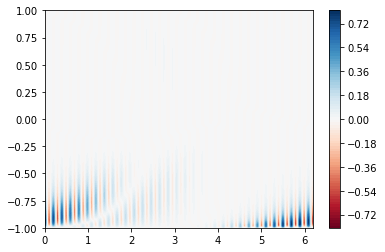

In [115]:
# Contours at z=0 (z is spanwise)
nz = uPhysDict['zArr'].size
xArr = uPhysDict['xArr']; yArr = uPhysDict['yArr']
plt.contourf(xArr, yArr, uPhysDict['arrPhys'][:,nz//2+1,:].T, 100,cmap='RdBu')
plt.colorbar()
plt.show()

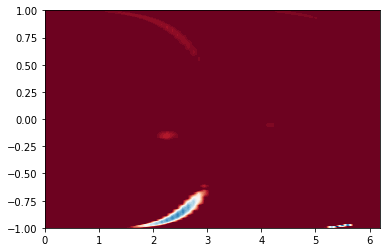

In [109]:
# Contours at z=0 (z is spanwise)
nz = swirlPhysDict['zArr'].size
xArr = swirlPhysDict['xArr']; yArr = swirlPhysDict['yArr']
plt.contourf(xArr, yArr, swirlPhysDict['swirl'][:,nz//2,:].T, 50,cmap='RdBu')
plt.show()

# Save physical fields to .mat file 

In [111]:
fNamePhys = 'testFields/testImpres_physEddyRe%dy0p%d'%(Re,int(round(-1000*y0)))+ \
                _suffix(fsVec, t)

nx = ff.shape[0]; nz = 2*(ff.shape[1]-1)
ff.savePhysical(fieldList=['u','v','w','vorx','swirl','vory','vorz'],
            fName=fNamePhys,
            x0=10.*t, lx=min(25.*t,((nx-2)/nx)*Lx), 
            z0=min(10.*t,((nz-2)/nz)*Lz),
            )

/home/svadarevu/gitwork/linear/library/flowField.py:729: UserWarning: Ensure input arr confirms to fft order for wavenumbers
  warn("Ensure input arr confirms to fft order for wavenumbers")
/home/svadarevu/gitwork/linear/library/flowField.py:1220: UserWarning: Assuming that modes go positive and negative in kx
  warn("Assuming that modes go positive and negative in kx")


Saved fields   ['u', 'v', 'w', 'swirl', 'vorx', 'vory', 'vorz']   to file testFields/testImpres_physEddyRe500y0p950_Fs_1_0_0_t00050.mat


# Load flowFields, post-processing for data used in the paper

/home/svadarevu/gitwork/linear/library/flowField.py:783: UserWarning: Using channel geometry, excluding walls; see kwargs of pseudo.chebdif() and pseudo.weightMats() for differentiation/integration matrices that could include walls.
  warn("Using channel geometry, excluding walls; see kwargs of pseudo.chebdif() and pseudo.weightMats() for differentiation/integration matrices that could include walls.")


Loaded flowField from  /kepler/sabarish/impulseResponse/ffEddyRe10000y0p997_Fs_1_0_0_t00030.mat


/home/svadarevu/gitwork/linear/library/flowField.py:968: UserWarning: Ensure input arr confirms to fft order for wavenumbers
  if doSort:
/home/svadarevu/gitwork/linear/library/flowField.py:1593: UserWarning: Assuming that modes go positive and negative in kx
  if M is None : M = M0


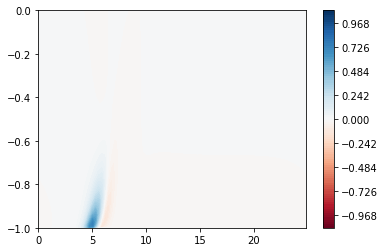

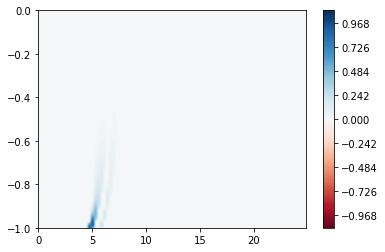

In [223]:
saveFolder = '/kepler/sabarish/impulseResponse/'
specPrefix = saveFolder+'ffEddyRe10000'

fName = specPrefix+'y0p997_Fs_1_0_0_t00030.mat'
ff = flowField.loadff(fName)

# Streamwise velocity in physical space:
#uPhysDict = ff.toPhysical(arr=ff[:,:,0], x0=12*ff.flowDict['t'], lx=15.*ff.flowDict['t'], 
#              z0=5.*ff.flowDict['t'], ySpace='cheb', doSort=True, L=L, M=M)
# 'arr' field that is being transformed to physical space
# x0, lx, and z0 specify the physical domain. If set to None, 
#    0., Lx, and -Lz/2. are used. 
# ySpace can be 'cheb' or 'linear'. 
# doSort refers to having to sort aArr and bArr into fft-order. Set to True if unsure. 
# L and M are the number of positive streamwise and spanwise wavenumbers 
#   if they're greater/lesser than the ones used in creating ff, then 
#   the flowfield are padded/truncated. 
# vPhysDict is a dict with keys 'arrPhys', 'xArr', 'yArr', 'zArr'
uPhysDict = ff.toPhysical(arr=ff[:,:,0],doSort=True)

# Swirling strength
#swirlPhysDict = ff.swirl(x0=12*ff.flowDict['t'], lx=15.*ff.flowDict['t'], 
#              z0=5.*ff.flowDict['t'], ySpace='cheb', doSort=True, L=2*L, M=2*M)
swirlPhysDict = ff.swirl(doSort=True)
# Dict contains keys 'swirl', 'xArr', 'yArr', 'zArr'


# Contours at z=0 (z is spanwise)
nz = uPhysDict['zArr'].size

xArr = uPhysDict['xArr']; yArr = uPhysDict['yArr']
uMax = np.amax(uPhysDict['arrPhys'].flatten())
levels = 1.1* np.linspace(-1.,1.,101)
plt.contourf(xArr, yArr, uPhysDict['arrPhys'][:,nz//2+1,:].T/uMax, levels=levels,cmap='RdBu')
plt.ylim([-1.,-0])
plt.colorbar()
plt.show()

xArr = swirlPhysDict['xArr']; yArr = swirlPhysDict['yArr']
swirlMax = np.amax(swirlPhysDict['swirl'].flatten())
levels = 1.1* np.linspace(-1.,1.,101)
plt.contourf(xArr, yArr, swirlPhysDict['swirl'][:,nz//2+1,:].T/swirlMax, 
            levels=levels,cmap='RdBu')
plt.ylim([-1.,-0])
plt.colorbar()
plt.show()

## Eddy intensity functions, and near wall turbulence intensities

In [239]:

#============
# Three data sets exist on disk at dataFolder, 
# Two sets at Re=1e4,
#    for y0plus=30,500,5000 with impulse 'width' given by eps=y0plus/4
#    for y0plus=500 with impulse width given by eps=y0plus
# One set at Re=1e5,
#    for y0plus=500 with impulse width given by eps=y0plus
# The prefixes of file name for the 3 sets are
# ffEddyRe10000, ffEddyEpsY0Re10000, and ffEddyRe1E5 respectively
#=====
caseIndex = 0 # Set to 0,1, or 2 to choose one of the cases below
ReList = [1.e4, 1.e4, 1.e5]
NList = [768, 512, 1024]
fPrefixList = ['ffEddyRe10000','ffEddyEpsY0Re10000','ffEddyRe1E5']
Re = ReList[caseIndex]; fPrefix=fPrefixList[caseIndex]; N=NList[caseIndex]
if caseIndex == 0:
    y0pArr = np.array([30., 500., 5000.])
else :
    y0pArr = np.array([500.])

tArr = np.arange(0.05, 1.5,0.05)  # Same times (scaled by uTau and h) for all cases
#==========

y0Arr = -1. + y0pArr/Re
fNameFun = lambda y0,fsVec, t: dataFolder+fPrefix+\
        'y0p%03d_Fs_%d_%d_%d_t%05d.mat'%(
                int(round(-1000.*y0)),fsVec[0],fsVec[1],fsVec[2],int(round(100.*t)) )
fsAmp = np.identity(3)


print("Case Index:",caseIndex)
print("Re,N,fPrefix:", Re,N,fPrefix)

Case Index: 0
Re,N,fPrefix: 10000.0 768 ffEddyRe10000


In [240]:
saveFileList = ['eddyIntRe1E4.mat', 'eddyIntEpsY0Re1E4.mat', 'eddyIntRe1E5.mat']
saveFileName = dataFolder + saveFileList[caseIndex]
# Extract these functions from ff, and save to disk for each case for later access
# The following arrays will be saved to disk as a .mat file for each case
eddyIntArr = np.zeros((y0Arr.size, fsAmp.shape[0], tArr.size, 6, N)) 
# Fourth index corresponds to uu,vv,ww,uv,uw, and vw in that order
dhArr = np.zeros((y0Arr.size,fsAmp.shape[0],tArr.size)) # eddy height

for i0 in range(y0Arr.size):
    y0 = y0Arr[i0]
    for i1 in range(fsAmp.shape[0]):
        fsVec = fsAmp[i1]
        for i2 in range(tArr.size):
            t = tArr[i2]
            
            fName = fNameFun(y0, fsVec, t)
            ff = flowField.loadff(fName)
            
            outDict = ff.eddyInt(lowerHalf=True)
            # Returns a dict with keys
            #  uu, vv, ww, uv, uw, vw, yArr, and dh
            # Here, v is wall-normal velocity, dh is streak height
            
            eddyIntArr[i0,i1,i2,0] = outDict['uu']
            eddyIntArr[i0,i1,i2,1] = outDict['vv']
            eddyIntArr[i0,i1,i2,2] = outDict['ww']
            eddyIntArr[i0,i1,i2,3] = outDict['uv']
            eddyIntArr[i0,i1,i2,4] = outDict['uw']
            eddyIntArr[i0,i1,i2,5] = outDict['vw']
            # Eddy intensities are definied in a half-plane
            
            dhArr[i0,i1,i2] = outDict['dh']

# Collect the above arrays and a few others into a dict to save to .mat 
eddyIntDict = {'eddyIntArr':eddyIntArr, 'dhArr':dhArr,\
        'y0Arr':y0Arr, 'tArr':tArr, 'fsAmp':fsAmp,'Re':Re, 'N':N,'y':ff.y}      

savemat(saveFileName, eddyIntDict)
print('Saved eddy intensity related arrays to', saveFileName)

/home/svadarevu/gitwork/linear/library/flowField.py:783: UserWarning: Using channel geometry, excluding walls; see kwargs of pseudo.chebdif() and pseudo.weightMats() for differentiation/integration matrices that could include walls.
  warn("Using channel geometry, excluding walls; see kwargs of pseudo.chebdif() and pseudo.weightMats() for differentiation/integration matrices that could include walls.")


Loaded flowField from  /kepler/sabarish/impulseResponse/ffEddyRe10000y0p997_Fs_1_0_0_t00005.mat


/home/svadarevu/gitwork/linear/library/flowField.py:968: UserWarning: Ensure input arr confirms to fft order for wavenumbers
  warn("Ensure input arr confirms to fft order for wavenumbers")
/home/svadarevu/gitwork/linear/library/flowField.py:1594: UserWarning: Assuming that modes go positive and negative in kx
  if (L is not None) or (M is not None):
/home/svadarevu/gitwork/linear/library/flowField.py:1463: UserWarning: Normalized height for eddyInt is returned as eddyIntDict['yArr']
  


Loaded flowField from  /kepler/sabarish/impulseResponse/ffEddyRe10000y0p997_Fs_1_0_0_t00010.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/ffEddyRe10000y0p997_Fs_1_0_0_t00015.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/ffEddyRe10000y0p997_Fs_1_0_0_t00020.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/ffEddyRe10000y0p997_Fs_1_0_0_t00025.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/ffEddyRe10000y0p997_Fs_1_0_0_t00030.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/ffEddyRe10000y0p997_Fs_1_0_0_t00035.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/ffEddyRe10000y0p997_Fs_1_0_0_t00040.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/ffEddyRe10000y0p997_Fs_1_0_0_t00045.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/ffEddyRe10000y0p997_Fs_1_0_0_t00050.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/ffEddyRe10000y0p997_Fs_1_0_0_t00055.mat
Loaded flowField from  /kepler/sabarish/

## Plotting eddy intensity functions for fig.4 in the paper

In [10]:
dataFolder = '/kepler/sabarish/impulseResponse/'
# Set to False if continuing from previous cells
if True :
    caseIndex = 2
    saveFileList = ['eddyIntRe1E4.mat', 'eddyIntEpsY0Re1E4.mat', 'eddyIntRe1E5.mat']
    saveFileName = dataFolder + saveFileList[caseIndex]
    loadDict = loadmat(saveFileName)
    eddyIntArr = loadDict['eddyIntArr']
    dhArr = loadDict['dhArr']
    y0Arr = loadDict['y0Arr'].flatten() 
    # Need to flatten saving/loading .mat files regards 1d numpy arrays as column vectors
    tArr = loadDict['tArr'].flatten()
    y = loadDict['y'].flatten()  # eddy intensities start from wall
    # Ensure y goes from -1, since that is where the bottom wall is
    fsAmp = loadDict['fsAmp']
    Re = float(loadDict['Re'])
    N = eddyIntArr.shape[-1]

y0ForSuffix = lambda y0, fsVec: 'y0p%03d_Fs_%d_%d_%d'%(round(-1000.*y0),
                                fsVec[0],fsVec[1],fsVec[2])


def clamp(x): 
    if x <= 1.: x = 256*x
    return int(max(0, min(x, 255)))

def rgb2hex(tup):
    hexstr = "#{0:02x}{1:02x}{2:02x}".format(
        clamp(tup[0]), clamp(tup[1]), clamp(tup[2]) )
    return hexstr

    
def plotEddyInt_uu_uv(t0,t1, tStep, 
        logScale=True,y0Ind=0,fsInd=0,
        saveEps=False, saveTikz=True,
        fName=None, yMax=1.75, figPrefix='eddyInt'):
    warn("Labels assume y is wall-normal. Change this if needed, preferably in tikz files.")
    y0 = y0Arr[y0Ind]
    fsVec = fsAmp[fsInd]
    if (saveTikz or saveEps) and (fName is None):
        if not logScale:
            fName = figPrefix+'Re%d%s.eps'%(Re, y0ForSuffix(y0,fsVec)  )
        else :
            fName = figPrefix+'LogRe%d%s.eps'%(Re, y0ForSuffix(y0,fsVec)  )
    uuMax = 1
    fig, ax1 = plt.subplots()
    ax2 = ax1.twiny()
    yPeakUU = 0.
    yPeakUV = 0.
    ctr = 0
    for i2 in range(t0,t1,tStep):
        if dhArr[y0Ind,fsInd,i2] > 0.5:
            lStyle =':'
        else :
            lStyle = '--'
        yPeakUU += (1+y[N//2:])[np.argmax(eddyIntArr[y0Ind,fsInd,i2,0][N//2:])]/\
                    dhArr[y0Ind,fsInd,i2]
        yPeakUV += (1+y[N//2:])[np.argmin(eddyIntArr[y0Ind,fsInd,i2,3][N//2:])]/\
                    dhArr[y0Ind,fsInd,i2]
        ctr += 1
        
        clrRB = rgb2hex(( i2/tArr.size, 0., 1. - i2/tArr.size  ))
        #clrYG = rgb2hex(( 1.-i2/t1, 0.8+0.2*(i2/(t1-1)), 0.))
        clrYG = rgb2hex(( 0., i2/(t1-1), 0.))
        
        ax1.plot(eddyIntArr[y0Ind,fsInd,i2,0][N//2:],
                (1.+y[N//2:])/(dhArr[y0Ind,fsInd,i2]), 
                color = clrRB)
        ax2.plot(eddyIntArr[y0Ind,fsInd,i2,3][N//2:],
                (1.+y[N//2:])/(dhArr[y0Ind,fsInd,i2]), 
                color = clrYG,linestyle=lStyle  )
        uuMax = max( uuMax, np.amax(eddyIntArr[y0Ind,fsInd,i2,0])  )
        
    yPeakUU = yPeakUU/ctr
    yPeakUV = yPeakUV/ctr
    rangeArr = np.arange(0.,1., 0.02)
    #ax1.plot(0.*rangeArr, yMax*rangeArr,'k:' )
    plt.grid('on')
    ax2.plot(-1.2*rangeArr, yPeakUV+0.*rangeArr, 'y-.')
    ax2.plot(1.2*rangeArr, yPeakUU+0.*rangeArr, 'c-.')
    
    ax1.set_ylim([0., yMax])
    ax1.set_xlim([-1.1*uuMax, 1.1*uuMax])
    ax2.set_xlim([-1.1, 1.1])
    ax1.set_ylabel("$(1+y)/\\delta_h$", fontsize=12)
    ax1.set_xlabel("$I_{11}$", fontsize=12, color=rgb2hex((0.5,0.,0.5)))
    #ax2.set_xlabel("$I_{12}$", fontsize=12, color=rgb2hex((0.5,1.,0.)) )
    ax2.set_xlabel("$I_{12}$", fontsize=12, color=rgb2hex((0.,0.5,0.)) )
    ax1.tick_params('x', colors=rgb2hex((0.5,0.,0.5)))
    #ax2.tick_params('x', colors=rgb2hex((0.5,1.,0.)) )
    ax2.tick_params('x', colors=rgb2hex((0.,0.5,0.)) )
    if logScale:
        ax1.set_yscale("log")
        ax1.set_ylim([0.0005, yMax])

    
    
    if saveEps:
        savefig(fName)
    if saveTikz:
        tikzSaveSmall(fName)
    plt.show()    

    
def plotTurbInt_uu(t0,t1, tStep, 
        logScale=True,y0Ind=0,fsInd=0,
        saveEps=False, saveTikz=True,
        fName=None, yMax=1.75,figPrefix='turbInt'):
    warn("Labels assume y is wall-normal. Change this if needed, preferably in tikz files.")
    y0 = y0Arr[y0Ind]
    fsVec = fsAmp[fsInd]
    if (saveTikz or saveEps) and (fName is None):
        if not logScale:
            fName = figPrefix+'Re%d%s.eps'%(Re, y0ForSuffix(y0,fsVec)  )
        else :
            fName = figPrefix+'LogRe%d%s.eps'%(Re, y0ForSuffix(y0,fsVec)  )
    uuMax = 1
    plt.figure()
    if logScale: 
        yIndMax = np.argwhere((Re*(1.+y))< 100.).flatten()[0]
    else :
        yIndMax = np.argwhere((Re*(1.+y))< 30.).flatten()[0]
        
    for i2 in range(t0,t1,tStep):
        clrRB = rgb2hex(( i2/tArr.size, 0., 1. - i2/tArr.size  ))
        uuMax = max( uuMax, np.amax(eddyIntArr[y0Ind,fsInd,i2,0])  )
        #plt.plot((eddyIntArr[y0Ind,fsInd,i2,0][N//2:])/uuMax,
        #        Re*(1.+y[N//2:]), 
        #        color = clrRB)
        plt.plot((eddyIntArr[y0Ind,fsInd,i2,0][yIndMax:])/uuMax,
                Re*(1.+y[yIndMax:]), 
                color = clrRB)
    
    if logScale:
        plt.yscale("log")
        plt.ylim([1., 50.])
        plt.xlim([0., 0.4])
    else :
        plt.ylim([0., 15.])
        plt.xlim([0., 0.25])
    plt.grid('on')
    plt.ylabel("$y^+$", fontsize=12)
    plt.xlabel("$I_{11}/I_{11,max}$", fontsize=12, color=rgb2hex((0.5,0.,0.5)))
    plt.tick_params('x', color=rgb2hex((0.5,0.,0.5)))
    
    if saveEps:
        savefig(fName)
    if saveTikz:
        tikzSaveSmall(fName)
    plt.show()    


/home/svadarevu/linenv/lib/python3.5/site-packages/ipykernel/__main__.py:62: UserWarning: Labels assume y is wall-normal. Change this if needed, preferably in tikz files.


Printed figure to  testFigures/eddyIntRe100000y0p995_Fs_1_0_0.eps
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Saved tikz file to  testFigures/eddyIntRe100000y0p995_Fs_1_0_0.tex


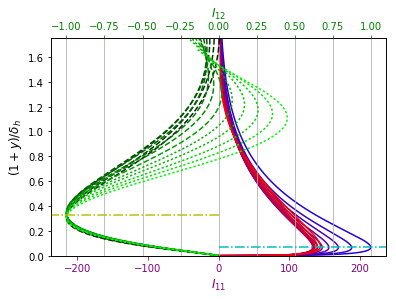

Printed figure to  testFigures/eddyIntLogRe100000y0p995_Fs_1_0_0.eps
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Saved tikz file to  testFigures/eddyIntLogRe100000y0p995_Fs_1_0_0.tex


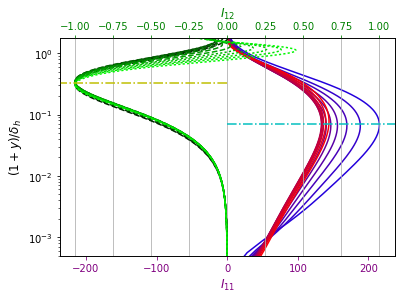

/home/svadarevu/linenv/lib/python3.5/site-packages/ipykernel/__main__.py:132: UserWarning: Labels assume y is wall-normal. Change this if needed, preferably in tikz files.


Printed figure to  testFigures/turbIntRe100000y0p995_Fs_1_0_0.eps
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Saved tikz file to  testFigures/turbIntRe100000y0p995_Fs_1_0_0.tex


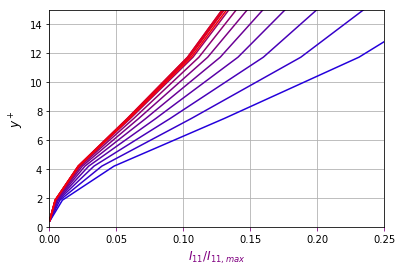

Printed figure to  testFigures/turbIntLogRe100000y0p995_Fs_1_0_0.eps
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Saved tikz file to  testFigures/turbIntLogRe100000y0p995_Fs_1_0_0.tex


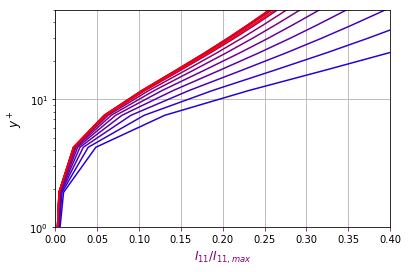

Printed figure to  testFigures/eddyIntRe100000y0p995_Fs_0_1_0.eps
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Saved tikz file to  testFigures/eddyIntRe100000y0p995_Fs_0_1_0.tex


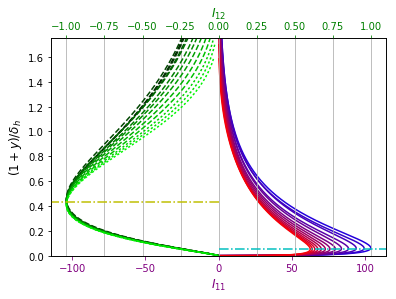

Printed figure to  testFigures/eddyIntLogRe100000y0p995_Fs_0_1_0.eps
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Saved tikz file to  testFigures/eddyIntLogRe100000y0p995_Fs_0_1_0.tex


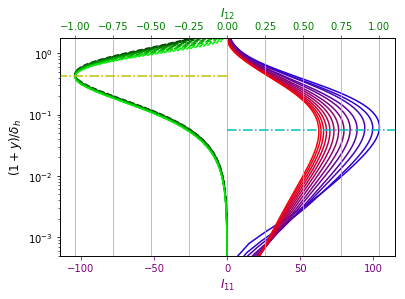

Printed figure to  testFigures/turbIntRe100000y0p995_Fs_0_1_0.eps
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Saved tikz file to  testFigures/turbIntRe100000y0p995_Fs_0_1_0.tex


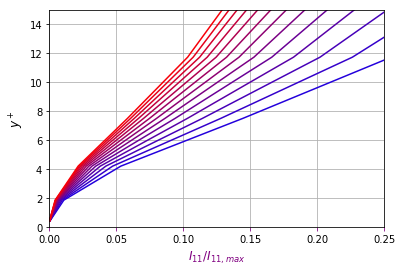

Printed figure to  testFigures/turbIntLogRe100000y0p995_Fs_0_1_0.eps
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Saved tikz file to  testFigures/turbIntLogRe100000y0p995_Fs_0_1_0.tex


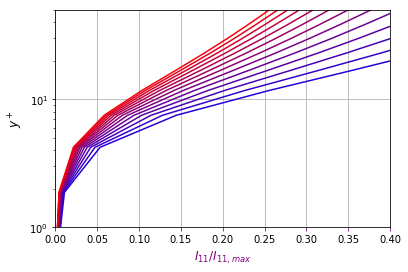

Printed figure to  testFigures/eddyIntRe100000y0p995_Fs_0_0_1.eps
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Saved tikz file to  testFigures/eddyIntRe100000y0p995_Fs_0_0_1.tex


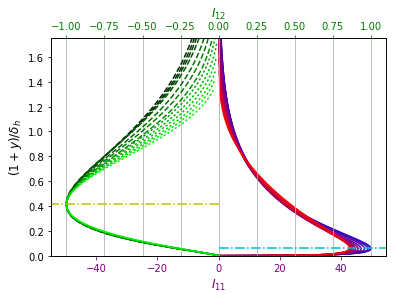

Printed figure to  testFigures/eddyIntLogRe100000y0p995_Fs_0_0_1.eps
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Saved tikz file to  testFigures/eddyIntLogRe100000y0p995_Fs_0_0_1.tex


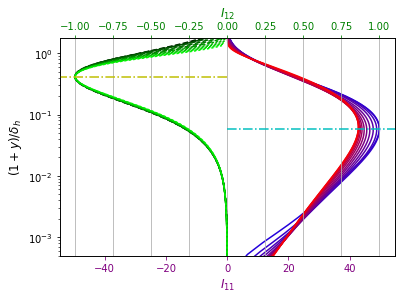

Printed figure to  testFigures/turbIntRe100000y0p995_Fs_0_0_1.eps
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Saved tikz file to  testFigures/turbIntRe100000y0p995_Fs_0_0_1.tex


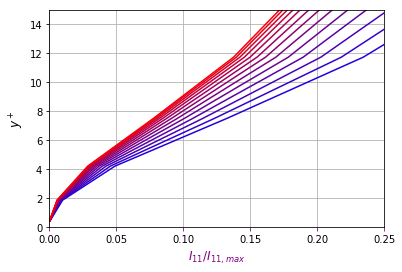

Printed figure to  testFigures/turbIntLogRe100000y0p995_Fs_0_0_1.eps
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Saved tikz file to  testFigures/turbIntLogRe100000y0p995_Fs_0_0_1.tex


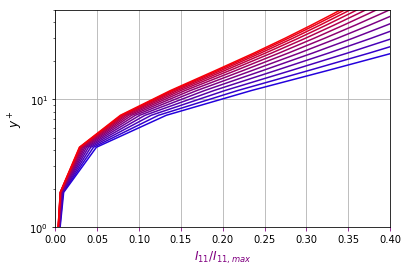

In [11]:
figPrefix1List = ['eddyInt', 'eddyIntEpsY0','eddyInt']
figPrefix2List = ['turbInt', 'turbIntEpsY0','turbInt']
figPrefix1 = figPrefix1List[caseIndex]
figPrefix2 = figPrefix2List[caseIndex]

for i0 in range(y0Arr.size):
    if i0 == 2: yMax = 1.25
    else : yMax = 1.75
    for i1 in range(fsAmp.shape[0]):
        plotEddyInt_uu_uv(4,30,2,logScale=False,fsInd=i1,y0Ind=i0,
                         saveTikz=True, saveEps=True, yMax = yMax,figPrefix=figPrefix1)
        plotEddyInt_uu_uv(4,30,2,logScale=True ,fsInd=i1,y0Ind=i0,
                         saveTikz=True, saveEps=True, yMax = yMax,figPrefix=figPrefix1)
        
        plotTurbInt_uu(4,30,2,logScale=False,fsInd=i1,y0Ind=i0,
                         saveTikz=True, saveEps=True, yMax = yMax,figPrefix=figPrefix2)
        plotTurbInt_uu(4,30,2,logScale=True ,fsInd=i1,y0Ind=i0,
                         saveTikz=True, saveEps=True, yMax = yMax,figPrefix=figPrefix2)
        

# Energy evolution

In [47]:
#=====
caseIndex = 1
ReList = [1.e4, 1.e4, 1.e5]
NList = [768, 512, 1024]
fPrefixList = ['ffEddyRe10000','ffEddyEpsY0Re10000','ffEddyRe1E5']

Re = ReList[caseIndex]; fPrefix=fPrefixList[caseIndex]; N=NList[caseIndex]
if caseIndex == 0:
    y0pArr = np.array([30., 500., 5000.])
else :
    y0pArr = np.array([500.])

tArr = np.arange(0.05, 1.5,0.05)  # Same times (scaled by uTau and h) for all cases
#==========

turbDict = ops.turbMeanChannel(N=N,Re=Re)
Umax = pseudo.chebint(turbDict['U'], [0.])
tArrCL = tArr*Umax

def plotEnergyDecay_xyz(tArr, energyArr, figName, saveFigs=False, saveTikz= False, plotTotal=True):
    symArr = ['+', 'v', 'x']
    vwMinLog = np.floor( np.log10( np.amin(
                (energyArr[:,:,1]+energyArr[:,:,2] ).flatten()) ))
    uvwMinLog = np.floor( np.log10(np.amin(
                energyArr[:,:,3].flatten()) ))
    vwMaxLog = np.ceil( np.log10( np.amax(
                (energyArr[:,:,1]+energyArr[:,:,2] ).flatten()) ))
    uvwMaxLog = np.ceil( np.log10(np.amax(
                energyArr[:,:,3].flatten()) ))
    dualAxis = False
    if dualAxis :
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()

    for i0 in range(fsAmp.shape[0]):
        if dualAxis :
            if False:
                ax1.semilogy(tArr, energyArr[i0,:,3], 'r%s--'%symArr[i0])
                ax2.semilogy(tArr, energyArr[i0,:,0], 'b%s:'%symArr[i0])
            else :
                ax1.loglog(tArr, energyArr[i0,:,3], 'r%s--'%symArr[i0])
                ax2.loglog(tArr, energyArr[i0,:,0], 'b%s:'%symArr[i0])
            
        else :
            plt.loglog(tArr, energyArr[i0,:,3], 'r%s--'%symArr[i0])
            plt.loglog(tArr, energyArr[i0,:,0], 'b%s:'%symArr[i0])
            

    if dualAxis:
        ax1.set_xlabel("$tU_{CL}/h$", fontsize=12)
        ax1.set_ylabel("$||\\mathbf{u}||$", fontsize=12, color='r')
        ax2.set_ylabel("$||u^2||$", fontsize=12, color='b')
        ax1.tick_params('y', colors='r')
        ax2.tick_params('y', colors='b')

        ax1.set_ylim([10**(uvwMinLog), 10**(uvwMaxLog)])
        ax2.set_ylim([10**(uvwMinLog), 10**(uvwMaxLog) ])
    else :
        plt.xlabel("$tU_{CL}/h$", fontsize=12)
        plt.ylabel("Energy", fontsize=12)

    if saveFigs:
        savefig(figName)
    if saveTikz:
        tikzSave(figName.split('.')[0]+'.tex',
                figurewidth='\\tmpFigWidth',
                figureheight='\\tmpFigHeight')
    plt.show()
    return

def getEnergy_xyz(fPrefix,y0):
    energyArr = np.zeros((fsAmp.shape[0], tArr.size, 4))
    for i0 in range(fsAmp.shape[0]):
        fsVec = fsAmp[i0]
        for i1 in range(tArr.size):
            fName = fPrefix+y0ForTimeSuffix(y0,fsVec, tArr[i1])
            ff = flowField.loadff(fName)
            energyArr[i0,i1,:3] = np.sum(np.sum(ff.modeWiseNorm(),axis=0), axis=0)
            energyArr[i0,i1,3] = np.sum(energyArr[i0,i1,:3])
    return energyArr


In [49]:
saveFigs = False; saveTikz = False

figName = 'energyDecayTimeEddy_EpsY0_Re1E4_I30.eps'
y0 = -0.950
energyArr = getEnergy_xyz(dataFolder+fPrefix,y0)
plotEnergyDecay_xyz(tArrCL, energyArrKine26, figName, saveFigs=saveFigs, saveTikz=saveTikz, plotTotal=True)
    





/home/svadarevu/gitwork/linear/library/flowField.py:796: UserWarning: Using channel geometry, excluding walls; see kwargs of pseudo.chebdif() and pseudo.weightMats() for differentiation/integration matrices that could include walls.
  warn("Using channel geometry, excluding walls; see kwargs of pseudo.chebdif() and pseudo.weightMats() for differentiation/integration matrices that could include walls.")


Loaded flowField from  /kepler/sabarish/impulseResponse/ffEddyEpsY0Re10000y0p950_Fs_1_0_0_t00005.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/ffEddyEpsY0Re10000y0p950_Fs_1_0_0_t00010.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/ffEddyEpsY0Re10000y0p950_Fs_1_0_0_t00015.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/ffEddyEpsY0Re10000y0p950_Fs_1_0_0_t00020.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/ffEddyEpsY0Re10000y0p950_Fs_1_0_0_t00025.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/ffEddyEpsY0Re10000y0p950_Fs_1_0_0_t00030.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/ffEddyEpsY0Re10000y0p950_Fs_1_0_0_t00035.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/ffEddyEpsY0Re10000y0p950_Fs_1_0_0_t00040.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/ffEddyEpsY0Re10000y0p950_Fs_1_0_0_t00045.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/ffEddyEpsY0Re10000y0p950_Fs_1_0_0_t

NameError: name 'energyArrKine26' is not defined

# Resolvent Analysis; using flowField module

## Leading resolvent modes (response) for a single Fourier mode and phase speed

Compare with fig. 3b of Moarref et. al. (2013)

In [12]:
Re = 10000.; N = 401; turb=True; eddy=False
LxPlus = 700.; LzPlus = 100.; c = 10.
a = 2.*np.pi/(LxPlus/Re); b = 2.*np.pi/(LzPlus/Re)
omega = a*c
nSvals=10

print(omega/a)
ff = flowField.resolventMode(a,b,omega, N, Re, 
                turb=turb, eddy=eddy, modeNumber=1,modeSymm=2)
Lext = 25; Mext = 20
physDict = ff.toPhysical(ifft=False, L=Lext, M=Mext)
uPhys = physDict['arrPhys']; 
xArr = physDict['xArr'].flatten()
yArr = physDict['yArr'].flatten()
zArr = physDict['zArr'].flatten()
vPhysDict = ff.toPhysical(arr=ff[:,:,1],ifft=False, L=Lext, M=Mext)
vPhys = vPhysDict['arrPhys']; 
wPhysDict = ff.toPhysical(arr=ff[:,:,2],ifft=False, L=Lext, M=Mext)
wPhys = wPhysDict['arrPhys']; 


xNew = xArr.reshape((xArr.size,1,1))
zNew = zArr.reshape((1,zArr.size,1))
yNew = yArr.reshape((1,1,yArr.size))


10.0


/home/svadarevu/gitwork/linear/library/flowField.py:399: UserWarning: Calculating for (a,b,omega) and (-a,b,omega).
  warn("Calculating for (a,b,omega) and (-a,b,omega).")
/home/svadarevu/gitwork/linear/library/flowField.py:400: UserWarning: To set (-a,b,omega) coefficient to zero, set ff[-1] = 0, ff is the returned flowField instance.
  warn("To set (-a,b,omega) coefficient to zero, set ff[-1] = 0, ff is the returned flowField instance.")
/home/svadarevu/gitwork/linear/library/flowField.py:416: UserWarning: Same number for resolvent mode used for left and right leaning waves
  warn("Same number for resolvent mode used for left and right leaning waves")
/home/svadarevu/gitwork/linear/library/flowField.py:428: UserWarning: Same wall-normal symmetry is used for left and right leaning waves
  warn("Same wall-normal symmetry is used for left and right leaning waves")


Relative Frobenius-norm error for SVD is 0.378 for sparse=True with nSvals=2


/home/svadarevu/gitwork/linear/library/ops.py:559: UserWarning: getResolventModes(): velocityModes, forcingModes are shape (n_smodes, 3N), so each ROW is a mode, not column
  warn("getResolventModes(): velocityModes, forcingModes are shape (n_smodes, 3N), so each ROW is a mode, not column")
/home/svadarevu/gitwork/linear/library/flowField.py:521: UserWarning: For mode (-a,b), using reflexive symmetry about z=0 plane:
  warn("For mode (-a,b), using reflexive symmetry about z=0 plane:")
/home/svadarevu/gitwork/linear/library/flowField.py:522: UserWarning: [u,v,w](x,y,-z) = [u,v,-w](x,y,z)
  warn("[u,v,w](x,y,-z) = [u,v,-w](x,y,z)")
/home/svadarevu/gitwork/linear/library/flowField.py:523: UserWarning: Applied as u_{a,b}=u_{a,-b}=conj(u_{-a,b})=conj(u_{-a,-b})
  warn("Applied as u_{a,b}=u_{a,-b}=conj(u_{-a,b})=conj(u_{-a,-b})")
/home/svadarevu/gitwork/linear/library/flowField.py:524: UserWarning: This symmetry can be broken (shifted) by setting unequal phases for left and right leaning wav

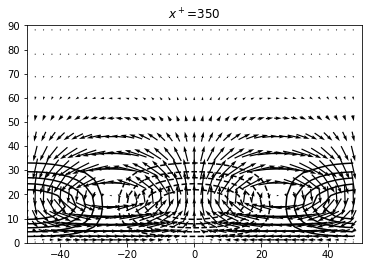

In [13]:
Y = yNew + np.zeros(xNew.shape) + np.zeros(zNew.shape)
Z = zNew + np.zeros(Y.shape)
X = xNew + np.zeros(Y.shape)


arr = uPhys
uMax = np.amax(arr.flatten())
#levels = np.arange(-15,16,3); levels= np.delete(levels,5)
levels = uMax*np.arange(-0.75,0.8,0.15); levels= np.delete(levels,5)
#for ix in [arr.shape[0]//2]:
for ix in [xArr.size//2]:
    plt.contour(zArr*Re, (1.+yArr)*Re, arr[ix].T, 
                colors='k',levels=levels)
    plt.quiver(Re*Z[ix],Re*(1.+Y[ix]), wPhys[ix],vPhys[ix],pivot='middle',units='y',width=0.5,scale=0.75,scale_units='y')
    plt.xlim([-50., 50]); plt.ylim([0., 90.])
    plt.title("$x^+$=%d"%(Re*xArr[ix]))
    plt.show()

if False:
    eddyIntDict = ff.eddyInt()
    yTmp = eddyIntDict['yArr']; uu = eddyIntDict['uu']; uv = eddyIntDict['uv']
    plt.plot(uu, yTmp, 'r-')
    plt.xlim([-1.1*np.amax(uu),1.1*np.amax(uu)])
    plt.show()

    plt.plot(uv, yTmp, 'g:')
    plt.xlim([-1.1,1.1])
    plt.show()
    

### Save the above flowField to .mat file for 3d plotting in Matlab

In [221]:
if not os.path.isdir('testFields'): os.mkdir("testFields")

# savePhysical() can produce physical fields using two routines:
#   ifft (from numpy) or a manual exponentiation routine. 
# ifft matches the number of grid points to the number of Fourier modes, 
#    so it's not advised for resolvent analysis 
ifft = False
doSort = False # This is needed when using ifft; we don't use it here
nx = 50; nz = 50 # Number of grid points to project the flowField on
fieldList = ['u','v','w','vorx','vory','vorz','swirl'] # These fields are supported in savePhysical
fName = "testFields/responseModeTest.mat"
x0=None ; lx = None; z0= None 
#These options are used to truncate the domain when box size is much larger than needed
ySpace = 'cheb' # Retain chebyshev nodes; alternate option is ySpace='linear'

ff.savePhysical(fieldList=fieldList,
                ifft=ifft, doSort=doSort, nx=nx, nz=nz,
                fName=fName, x0=x0,lx=lx, z0=z0, ySpace=ySpace)
    

Saved fields   ['u', 'v', 'w', 'swirl', 'vorx', 'vory', 'vorz']   to file testFields/responseModeTest.mat


# Resolvent analysis; without using flowField module

The ops.py module can produce resolvent modes and singular values, as well as account for symmetric and antisymmetric modes

## Singular values for a single Fourier mode and phase speed

Compare with fig.4a of Moarref et. al. (2013), Model-based scaling of streamwise energy density in high-Re turbulent channels

/home/svadarevu/gitwork/linear/library/ops.py:459: UserWarning: getResolventModes(): velocityModes, forcingModes are shape (n_smodes, 3N), so each ROW is a mode, not column
  warn("getResolventModes(): velocityModes, forcingModes are shape (n_smodes, 3N), so each ROW is a mode, not column")


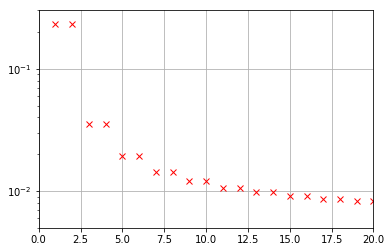

In [19]:
Re = 2003.; N = 251; turb=True; eddy=False
LxPlus = 700.; LzPlus = 100.; c = 10.
a = 2.*np.pi/(LxPlus/Re); b = 2.*np.pi/(LzPlus/Re)
omega = a*c

linInst = ops.linearize(N=N, Re=Re,turb=True)
resDict = linInst.getResolventModes(a,b,a*c, nSvals=20)

sVals = resDict['svals']
plt.semilogy(np.arange(1,sVals.size+1),sVals,'rx')
plt.ylim([0.005,0.3]); plt.xlim([0,20]); plt.grid('on')
plt.show()

##  Response modes

In [30]:
Re = 10000.; N = 401; turb=True; eddy=False
LxPlus = 700.; LzPlus = 100.; c = 10.
a = 2.*np.pi/(LxPlus/Re); b = 2.*np.pi/(LzPlus/Re)
omega = a*c
nSvals=10

linInst = ops.linearize(N=N, Re=Re,turb=True)
resDict = linInst.getResolventModes(a,b,a*c, nSvals=20)
velModes = resDict['velocityModes']

nx = 50; nz = 50
velMode1 = velModes[0].reshape((3,N))
velMode2 = velModes[1].reshape((3,N))
xArr = (2.*np.pi/a)*np.arange(0.,1.,1./nx)
zArr = (2.*np.pi/b)*np.arange(-0.5,0.5,1./nz)
yArr = linInst.y
xNew = xArr.reshape((xArr.size,1,1))
zNew = zArr.reshape((1,zArr.size,1))
yNew = yArr.reshape((1,1,yArr.size))

# Singular values come in pairs when Lx and Lz are smaller than channel half-height
# Linear combination of corresponding singular functions are also singular functions
# Use symmetries to distinguish them
symmDict = ops._modeSymms(velMode1,velMode2,N=N)
modeBottom = symmDict['bottom']
uSpec = modeBottom[0].reshape((1,1,N)) 
vSpec = modeBottom[1].reshape((1,1,N)) 
wSpec = modeBottom[2].reshape((1,1,N)) 

# Physical field at t=0, using reflectional symmetry. 
# See Eq. 2.12 of Moarref et. al. (2013) Model based scaling of ...
uPhys = 4.*np.cos(b*zNew) * np.real( uSpec* np.exp(1.j*a*xNew))
vPhys = 4.*np.cos(b*zNew) * np.real( uSpec* np.exp(1.j*a*xNew))
wPhys =-4.*np.sin(b*zNew) * np.imag( uSpec* np.exp(1.j*a*xNew))

Y = yNew + np.zeros(xNew.shape) + np.zeros(zNew.shape)
Z = zNew + np.zeros(Y.shape)
X = xNew + np.zeros(Y.shape)




Relative Frobenius-norm error for SVD is 0.325 for sparse=True with nSvals=20


/home/svadarevu/gitwork/linear/library/ops.py:559: UserWarning: getResolventModes(): velocityModes, forcingModes are shape (n_smodes, 3N), so each ROW is a mode, not column
  warn("getResolventModes(): velocityModes, forcingModes are shape (n_smodes, 3N), so each ROW is a mode, not column")


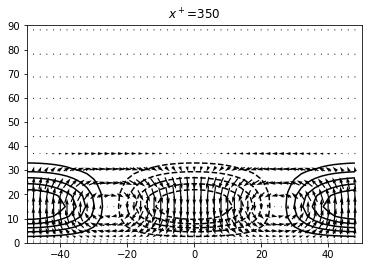

In [31]:
arr = uPhys
uMax = np.amax(arr.flatten())
#levels = np.arange(-15,16,3); levels= np.delete(levels,5)
levels = uMax*np.arange(-0.75,0.8,0.15); levels= np.delete(levels,5)
#for ix in [arr.shape[0]//2]:
for ix in [xArr.size//2]:
    plt.contour(zArr*Re, (1.+yArr)*Re, arr[ix].T, 
                colors='k',levels=levels)
    plt.quiver(Re*Z[ix],Re*(1.+Y[ix]), wPhys[ix],vPhys[ix],pivot='middle',units='y',width=0.5,scale=10,scale_units='y')
    plt.xlim([-50., 50]); plt.ylim([0., 90.])
    plt.title("$x^+$=%d"%(Re*xArr[ix]))
    plt.show()
